In [184]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from matplotlib import colors
import glob
from mpl_toolkits.mplot3d import Axes3D


# ------ LOAD THE DATA ------ #
dir = './output_new3/3d'
# dir = './outputs_new/3d_data/3d'
# --------------------- evacuation data --------------------- #
evacfiles = [f"{dir}/1000/gy-evac 3d-table.csv", 
             f"{dir}/5000/gy-evac 3d-table.csv", 
             f"{dir}/10000/gy-evac 3d-table.csv",
             f"{dir}/15000/gy-evac 3d-table.csv"]
evacdata_list = [pd.read_csv(file, skiprows=6) for file in evacfiles]
# concatenate the dataframes
evacdata = pd.concat(evacdata_list, ignore_index=True).sort_values(by=['initial-people', 'evacuation-probability', 'ticks']).reset_index(drop=True)
# rename the columns to something not cursed
evacdata.rename(columns={'[run number]': 'run_number'}, inplace=True)
evacdata.columns = evacdata.columns.str.replace('-', '_')
evacdata.rename(columns={'evacuation_probability': 'evp'}, inplace=True)
evacdata.rename(columns={'initial_people': 'population'}, inplace=True)
# calculate time in minutes
evacdata['time_minutes'] = evacdata['ticks'] * evacdata['tick_time_in_mins']
evacdata['evacuated_perc'] = evacdata['get_no_evacuated'] / evacdata['population'] * 100
evacdata['evacuating_perc'] = evacdata['get_no_evacuating'] / evacdata['population'] * 100

# ------------------ journey metrics ------------------ #
jm_dirs = [f"{dir}/1000", f"{dir}/5000", f"{dir}/10000", f"{dir}/15000"]
jm_files = [file for sublist in [glob.glob(f"{d}/jm*.csv") for d in jm_dirs] for file in sublist]
jm_list = [pd.read_csv(file) for file in jm_files]
# extract the evacuation proobability and population from the filename
for i, file in enumerate(jm_files):
    evp = float(file.split('/')[-1].split('_')[3][3:])  # evac prob
    pop = int(file.split('/')[-1].split('_')[2][1:])  # population
    jm_list[i]['evp'] = evp
    jm_list[i]['population'] = pop
    
journey_metrics = pd.concat(jm_list, ignore_index=True).sort_values(by=['population', 'evp', 'start_tick']).reset_index(drop=True)# calculate normalised journey time
journey_metrics['normalised_journey_time'] = journey_metrics['actual_time'] / journey_metrics['ideal_time']
# calculate time in minutes
journey_metrics['start_time_minutes'] = journey_metrics['start_tick'] * 0.3 # 1 tick = 0.3 mins


In [185]:
evacdata.head()

,run_number,terminate_evac_distance_km,population,max_walking_distance_km,warning_interval_time_mins,evp,tick_time_in_mins,over_break_probability,[step],ticks,get_no_active_cars,get_no_walking,get_no_evacuating,get_no_evacuated,get_no_in_cars,get_avg_no_people_per_car,time_minutes,evacuated_perc,evacuating_perc
0,1,0.3,1000,1,30,0.1,0.3,0.1,0,0,0,0,0,0,0,0.000000,0.0,0.0,0.0
1,1,0.3,1000,1,30,0.1,0.3,0.1,1,1,864,0,2441,49,2441,2.825231,0.3,4.9,244.1
2,1,0.3,1000,1,30,0.1,0.3,0.1,2,2,852,0,2406,84,2406,2.823944,0.6,8.4,240.6
3,1,0.3,1000,1,30,0.1,0.3,0.1,3,3,835,0,2360,130,2360,2.826347,0.9,13.0,236.0
4,1,0.3,1000,1,30,0.1,0.3,0.1,4,4,823,0,2335,155,2335,2.837181,1.2,15.5,233.5


In [186]:
journey_metrics.head()

,car_id,passengers,ideal_time,actual_time,start_tick,end_tick,evp,population,normalised_journey_time,start_time_minutes
0,28945,1,0.646875,0.6,0,1,0.2,1000,0.927536,0.0
1,24111,1,0.640625,0.6,0,1,0.2,1000,0.936585,0.0
2,22889,1,0.750625,0.6,0,1,0.2,1000,0.799334,0.0
3,7610,1,0.674375,0.6,0,1,0.2,1000,0.889713,0.0
4,1802,1,0.682500,0.9,0,2,0.2,1000,1.318681,0.0


In [187]:
# get data to plot 3D graph

# get the number of people evacuated at 6 hours
evacuated_at_6hours = evacdata[evacdata['time_minutes'] == 360].groupby(['population', 'evp'])['get_no_evacuated'].sum().reset_index()
evacuated_at_6hours.rename(columns={'get_no_evacuated': 'evac_after_6hrs'}, inplace=True)
evacuated_at_6hours

# calculate the percentage of people evacuated at 6 hours for each population
evacuated_at_6hours['perc_evacuated'] = evacuated_at_6hours['evac_after_6hrs'] / evacuated_at_6hours['population'] * 100

# get the average normalised journey time at in the first 6 hours
av_6hr_norm_jm = journey_metrics[journey_metrics['start_time_minutes'] < 360].groupby(['population', 'evp'])['normalised_journey_time'].mean().reset_index()
av_6hr_norm_jm.rename(columns={'normalised_journey_time': 'av_6hr_njt'}, inplace=True)

# merge the two dataframes
data_3d = pd.merge(av_6hr_norm_jm, evacuated_at_6hours, on=['population', 'evp'])


data_3d.head()

,population,evp,av_6hr_njt,evac_after_6hrs,perc_evacuated
0,1000,0.2,2.994185,928,92.80
1,1000,0.3,4.137413,979,97.90
2,1000,0.4,4.790932,997,99.70
3,1000,0.5,5.268460,998,99.80
4,5000,0.1,6.539656,3602,72.04


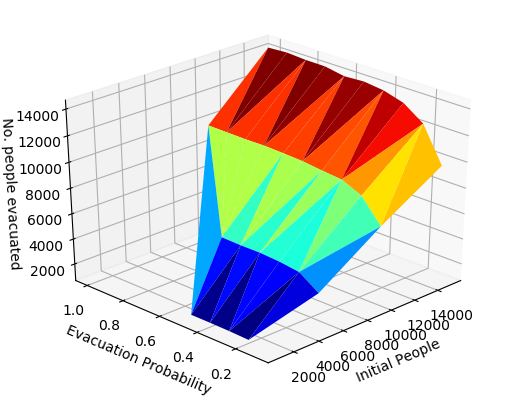

In [188]:
# plot the 3D graph: 6hr evacuated vs population & evp

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(data_3d['population'], data_3d['evp'],  data_3d['evac_after_6hrs'], cmap=plt.cm.jet, linewidth=0.01)
ax.view_init(30, 45)
ax.set_xlabel('Initial People')
ax.set_ylabel('Evacuation Probability')
ax.set_zlabel('No. people evacuated')
ax.invert_yaxis()
ax.invert_xaxis()
plt.show()

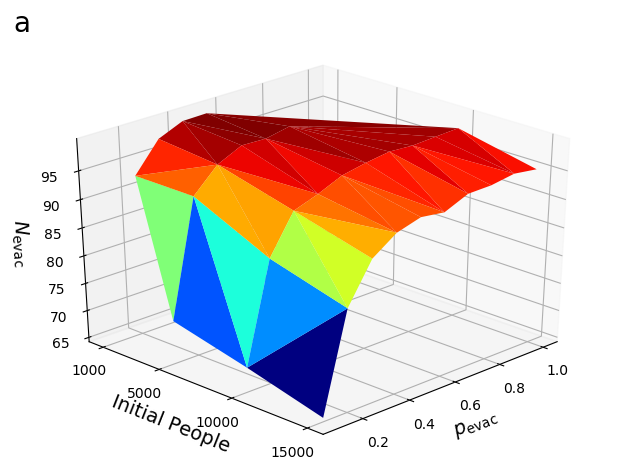

In [290]:
# plot the 3D graph: 6hr percentage evacuated vs population & evp

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(data_3d['evp'], data_3d['population'],  data_3d['perc_evacuated'], cmap=plt.cm.jet, linewidth=0.01)
ax.view_init(30, 45)
ax.set_ylabel('Initial People', fontsize=14)
ax.set_xlabel('$p_{\mathrm{evac}}$', fontsize=14)
#ax.set_zlabel('% people evacuated')
#ax.invert_yaxis()
ax.invert_xaxis()
ax.set_yticks([1000, 5000, 10000, 15000])
ax.set_zlabel('$N_{\mathrm{evac}}$', rotation=180, fontsize=14) # idk why rotation is not working
#plt.show()

plt.title('a', loc='left', fontsize=20)
plt.tight_layout()
plt.savefig('./figures_v02/evp_pop_3d_evac.png')

In [190]:
evacdata[evacdata['population'] ==1000].head()

,run_number,terminate_evac_distance_km,population,max_walking_distance_km,warning_interval_time_mins,evp,tick_time_in_mins,over_break_probability,[step],ticks,get_no_active_cars,get_no_walking,get_no_evacuating,get_no_evacuated,get_no_in_cars,get_avg_no_people_per_car,time_minutes,evacuated_perc,evacuating_perc
0,1,0.3,1000,1,30,0.1,0.3,0.1,0,0,0,0,0,0,0,0.000000,0.0,0.0,0.0
1,1,0.3,1000,1,30,0.1,0.3,0.1,1,1,864,0,2441,49,2441,2.825231,0.3,4.9,244.1
2,1,0.3,1000,1,30,0.1,0.3,0.1,2,2,852,0,2406,84,2406,2.823944,0.6,8.4,240.6
3,1,0.3,1000,1,30,0.1,0.3,0.1,3,3,835,0,2360,130,2360,2.826347,0.9,13.0,236.0
4,1,0.3,1000,1,30,0.1,0.3,0.1,4,4,823,0,2335,155,2335,2.837181,1.2,15.5,233.5


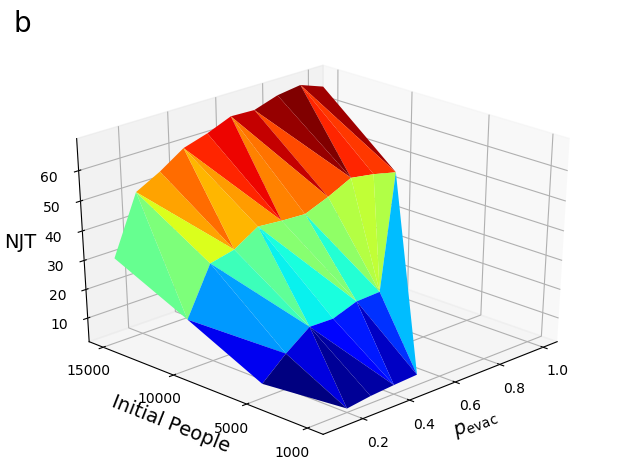

In [294]:
# plot the 3D graph: 6hr percentage evacuated vs population & evp

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(data_3d['evp'], data_3d['population'],  data_3d['av_6hr_njt'], cmap=plt.cm.jet, linewidth=0.01)
ax.view_init(30, 45)
ax.set_ylabel('Initial People', fontsize=14)
ax.set_xlabel('$p_{\mathrm{evac}}$', fontsize=14)
#ax.set_zlabel('% people evacuated')
ax.invert_yaxis()
ax.invert_xaxis()
ax.set_yticks([1000, 5000, 10000, 15000])
ax.set_zlabel('NJT', fontsize=14) # idk why rotation is not working
#plt.show()
plt.title('b', loc='left', fontsize=20)

plt.tight_layout()
plt.savefig('./figures_v02/evp_pop_3d_njt.png')

### NOTE

Note the y and y axes are inverted from % people evacuated and normalised journey time for visual clarity

# Timeseries and violin plots
---

- Population: fixing evp to 0.3
- evp: fixing population to 15000

## Evacuation probability

/home/amcquaid139/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == "":
/home/amcquaid139/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == "":
/home/amcquaid139/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == "":
/home/amcquaid139/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == "":
/home/amcquaid139/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == "":
/home/amcquaid139/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarn

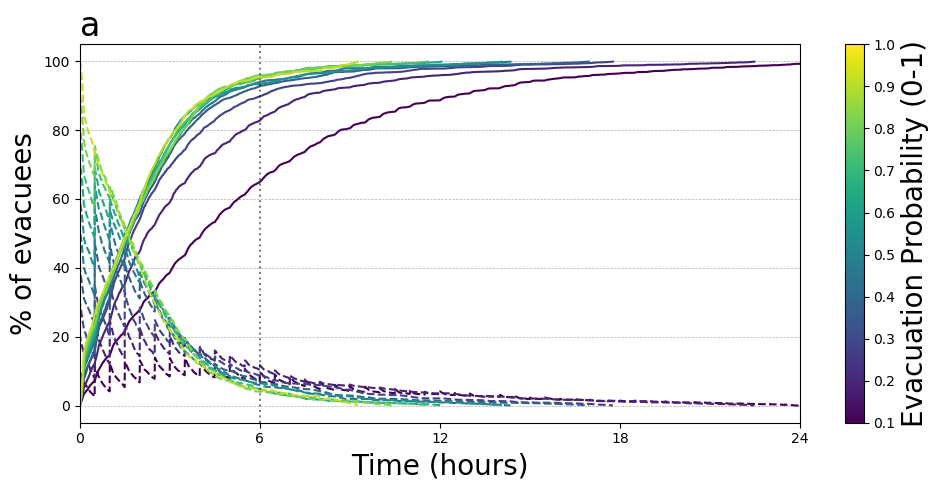

In [306]:
# NORMALISED JOURNEY TIMES TIME SERIES WITH MEAN AND STANDARD DEVIATION

fig, ax = plt.subplots(figsize=(10, 5))


c1='red' 
c2='gray'
n = len(list(evacdata['evp'].unique()))

# Plot each run
for i, ticktime in enumerate(evacdata['evp'].unique()):
    run_data = evacdata[evacdata['evp'] == ticktime][evacdata['population'] == 15000]
    color = plt.cm.viridis(i / n)  # Use the jet colormap
    plt.plot(run_data["time_minutes"]/60, run_data['evacuated_perc'], color=color)
    plt.plot(run_data["time_minutes"]/60, run_data['evacuating_perc'], linestyle='--', color=color)

# Update colorbar to use the jet colormap
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=evacdata['evp'].min(), vmax=evacdata['evp'].max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Evacuation Probability (0-1)', fontsize=20)

handles, labels = ax.get_legend_handles_labels()
#ax.legend(handles[::2], labels[::2])
ax.set_ylabel("% of evacuees", fontsize=20)
ax.set_xlabel('Time (hours)', fontsize=20)
ax.set_xlim(0, 24)
ax.yaxis.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.axvline(x=6, color='k', linestyle='dotted', alpha=0.5)
ax.set_xticks([0, 6, 12, 18, 24])

plt.title('a', loc='left', fontsize=24)
plt.tight_layout()

plt.savefig('./figures_v02/evac_timeseries_evp.png')


/home/amcquaid139/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/amcquaid139/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/amcquaid139/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/amcquaid139/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
No handles with labels found to put in legend.
/home/amcquaid139/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/amcquaid139/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFr

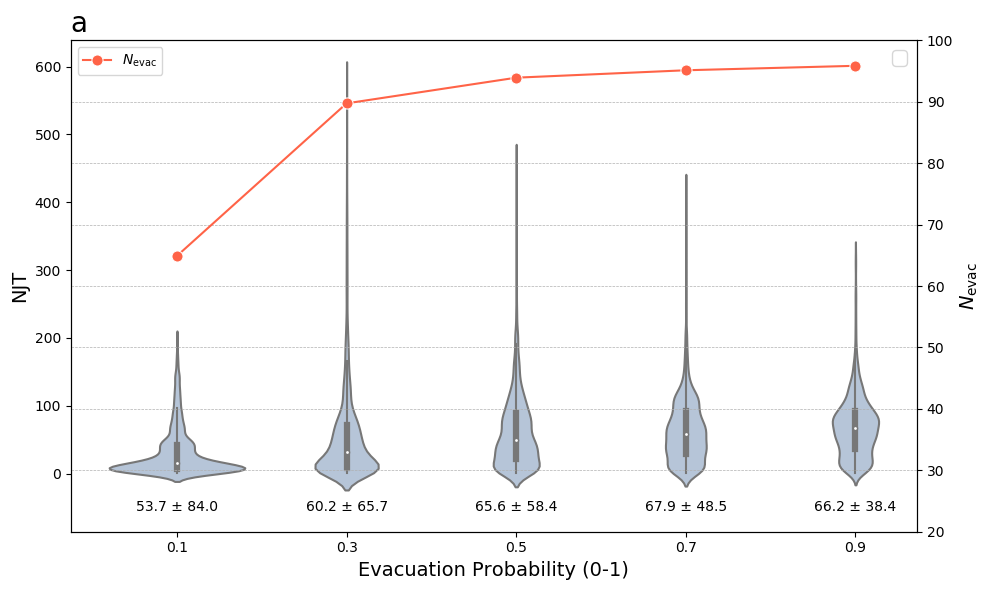

In [299]:
evacdata['evp_adj'] = (evacdata['evp'] * 5) - 0.5
fig, ax = plt.subplots(figsize=(10, 6))

# sns.violinplot(data=journey_metrics[journey_metrics['population'] == 15000][journey_metrics['evp'].isin([0.2, 0.4, 0.6, 0.8, 1.0])], x="evp", y="normalised_journey_time", color='lightsteelblue', ax=ax, label='Normalised Journey Time')
sns.violinplot(data=journey_metrics[journey_metrics['population'] == 15000][journey_metrics['start_time_minutes'] < 360][journey_metrics['evp'].isin([0.1, 0.3, 0.5, 0.7, 0.9])], x="evp", y="normalised_journey_time", color='lightsteelblue', ax=ax, label='NJT')

ax.set_ylabel('NJT', fontsize=14)
ax.set_xlabel('Evacuation Probability (0-1)', fontsize=14)#

# Get the x positions of the violin plots
x_positions = [patch.get_x() + patch.get_width() / 2 for patch in ax.patches]

ax2 = ax.twinx()
sns.lineplot(data=evacdata[evacdata['time_minutes'] == 360][evacdata['population'] == 15000][evacdata['evp'].isin([0.1, 0.3, 0.5, 0.7, 0.9])], x='evp_adj', y='evacuated_perc', color='tomato', ax=ax2, markers=True, marker='o', markersize=8, label='$N_{\mathrm{evac}}$')
#ax2.set_xticks(np.arange(30, 330, 30))

ax2.set_ylabel('$N_{\mathrm{evac}}$', fontsize=14)

# Create a combined legend
ax.legend(fontsize=14)

ax2.yaxis.grid(True, which='both', linestyle='--', linewidth=0.5)
ax2.set_ylim(20, 100)

# Calculate mean and standard deviation for each violin
means = journey_metrics[journey_metrics['population'] == 15000][journey_metrics['evp'].isin([0.2, 0.4, 0.6, 0.8, 1.0])].groupby('evp')['normalised_journey_time'].mean()
stds = journey_metrics[journey_metrics['population'] == 15000][journey_metrics['evp'].isin([0.2, 0.4, 0.6, 0.8, 1.0])].groupby('evp')['normalised_journey_time'].std()

# Offset the start of the y axis to make room for annotations
ax.set_ylim(bottom=ax.get_ylim()[0] - 30)

# Annotate mean and standard deviation
for i, evp in enumerate(means.index):
    mean = means[evp]
    std = stds[evp]
    ax.text(i, -55, f'{mean:.1f} ± {std:.1f}', horizontalalignment='center', size='small', color='black', fontsize=10)

plt.title('a', loc='left', fontsize=20)
plt.tight_layout()

plt.savefig('./figures_v02/njt_evac_violin_evp.png')

# Population

/home/amcquaid139/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == "":
/home/amcquaid139/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == "":
/home/amcquaid139/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == "":
/home/amcquaid139/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == "":


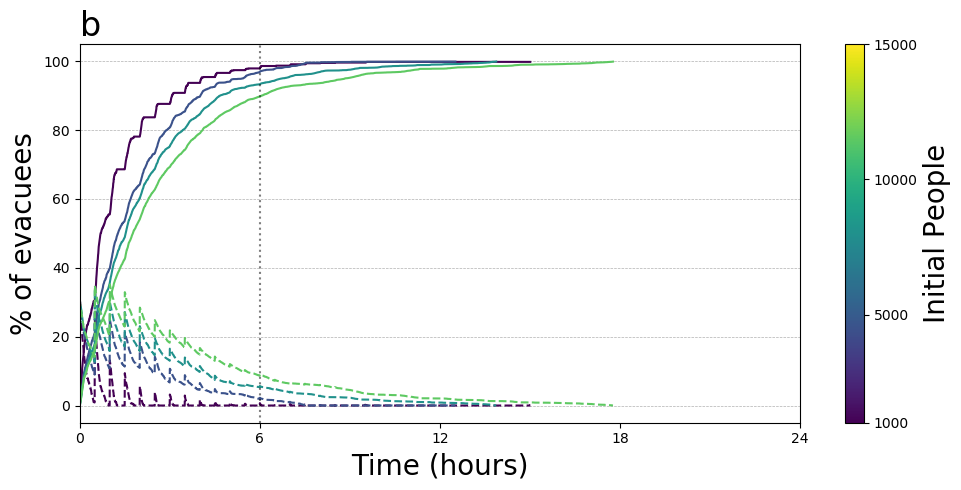

In [303]:
# NORMALISED JOURNEY TIMES TIME SERIES WITH MEAN AND STANDARD DEVIATION

fig, ax = plt.subplots(figsize=(10, 5))


c1='red' 
c2='gray'
n = len(list(evacdata['population'].unique()))

# Plot each run
for i, ticktime in enumerate(evacdata['population'].unique()):
    run_data = evacdata[evacdata['population'] == ticktime][evacdata['evp'] == 0.3]
    color = plt.cm.viridis(i / n)  # Use the jet colormap
    plt.plot(run_data["time_minutes"]/60, run_data['evacuated_perc'], color=color)
    plt.plot(run_data["time_minutes"]/60, run_data['evacuating_perc'], linestyle='--', color=color)

# Update colorbar to use the jet colormap
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=evacdata['population'].min(), vmax=evacdata['population'].max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Initial People', fontsize=20)
cbar.set_ticks([1000, 5000, 10000, 15000])

handles, labels = ax.get_legend_handles_labels()
#ax.legend(handles[::2], labels[::2])
ax.set_ylabel("% of evacuees", fontsize=20)
ax.set_xlabel('Time (hours)', fontsize=20)
ax.set_xlim(0, 24)
ax.yaxis.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.axvline(x=6, color='k', linestyle='dotted', alpha=0.5)
ax.set_xticks([0, 6, 12, 18, 24])

plt.title('b', loc='left', fontsize=24)
plt.tight_layout()

plt.savefig('./figures_v02/evac_timeseries_pop.png')

/home/amcquaid139/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/amcquaid139/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


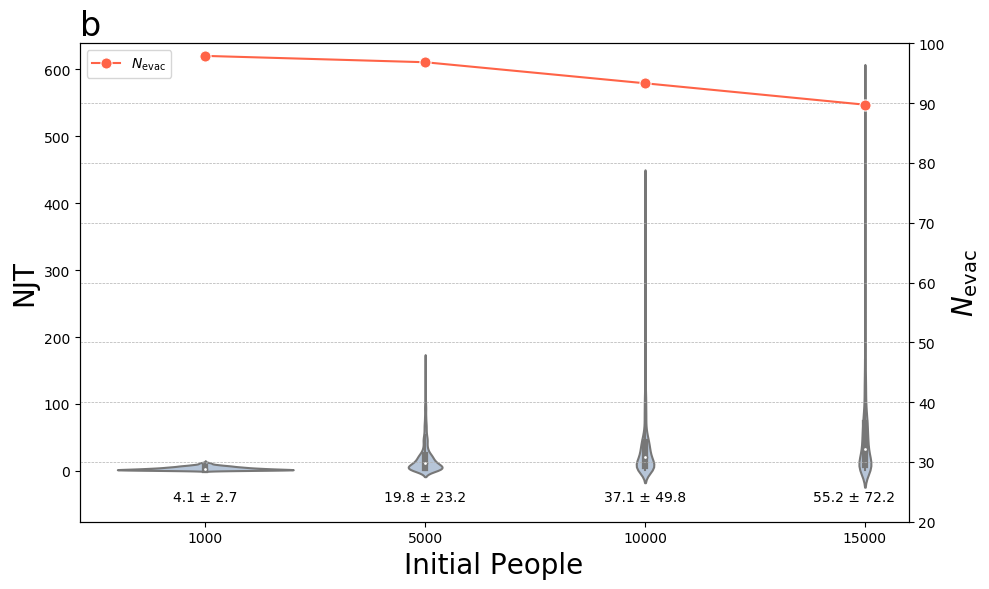

In [304]:
evacdata['pop_adj'] = (evacdata['population'] / 5000)
evacdata.loc[evacdata['population'] == 1000, 'pop_adj'] -= 0.2
fig, ax = plt.subplots(figsize=(10, 6))

sns.violinplot(data=journey_metrics[journey_metrics['evp'] == 0.3][journey_metrics['start_time_minutes'] < 360], x="population", y="normalised_journey_time", color='lightsteelblue', ax=ax, label='Normalised Journey Time')

ax.set_ylabel('NJT', fontsize=20)
ax.set_xlabel('Initial People', fontsize=20)

# Get the x positions of the violin plots
x_positions = [patch.get_x() + patch.get_width() / 2 for patch in ax.patches]

ax2 = ax.twinx()
sns.lineplot(data=evacdata[evacdata['time_minutes'] == 360][evacdata['evp']== 0.3], x='pop_adj', y='evacuated_perc', color='tomato', ax=ax2, markers=True, marker='o', markersize=8, label='$N_{\mathrm{evac}}$')
#ax2.set_xticks(np.arange(30, 330, 30))

ax2.set_ylabel('$N_{\mathrm{evac}}$', fontsize=20)

# Create a combined legend
ax2.legend(loc='upper left')

ax2.yaxis.grid(True, which='both', linestyle='--', linewidth=0.5)
ax2.set_ylim(20, 100)


# Calculate mean and standard deviation for each violin
means = journey_metrics[journey_metrics['evp'] == 0.3].groupby('population')['normalised_journey_time'].mean()
stds = journey_metrics[journey_metrics['evp'] == 0.3].groupby('population')['normalised_journey_time'].std()

# Offset the start of the y axis to make room for annotations
ax.set_ylim(bottom=ax.get_ylim()[0] - 20)

# Annotate mean and standard deviation
for i, evp in enumerate(means.index):
    mean = means[evp]
    std = stds[evp]
    if i != 3:
        ax.text(i, -45, f'{mean:.1f} ± {std:.1f}', horizontalalignment='center', size='small', color='black', fontsize=10)
    else:
        ax.text(i-0.05, -45, f'{mean:.1f} ± {std:.1f}', horizontalalignment='center', size='small', color='black', fontsize=10)

plt.title('b', loc='left', fontsize=24)
plt.tight_layout()

plt.savefig('./figures_v02/nkg_evac_violin_pop.png')